<h2><font color="gray">Prepared by: Muhammet Eren KÜÇÜK</font></h2>


<h1 style="color: firebrick; font-family: verdana"><b>Personality Classification</b></h1>

<h2 style="font-family: verdana"><b>1.1: Problem Definition</b></h2>

<p style="font-family: verdana">For this part of our assignment, we've been provided with a dataset that consists of 10000 samples with discrete 16 ground-truth class types, representing personality attributes. Each sample includes 60 attributes with their quantitive responds.</p>

<p style="font-family: verdana">Our objective is to read this dataset through the Numpy library to convert it to a Numpy array, split it into training and validation datasets using <b>5-fold cross validation</b>. After splitting our dataset, we need to make predictions using the test samples with <b>k-NN</b> and <b>weighted k-NN</b>. Our predictions will be performed in 4 ways:</p>

<ul>
    <li style="font-family: verdana">k-NN without feature normalization</li>
    <li style="font-family: verdana">k-NN with feature normalization</li>
    <li style="font-family: verdana">Weighted k-NN without feature normalization</li>
    <li style="font-family: verdana">Weighted k-NN with feature normalization</li>
</ul>

<p style="font-family: verdana">After our predictions, we must compare our predicted values with actual values, then use the predicted information to calculate <b>accuracy, precision and recall</b> values. We must do this with different k parameters <b>(1, 3, 5, 7 and 9)</b> for all of our 4 models.</p>

<h2 style="font-family: verdana"><b>1.2: Implementation of k-NN Classification</b></h2>

<p style="font-family: verdana">First; we need to import the necessary libraries for parsing the dataset, performing the intermediate array operations and displaying our results.</p>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

<p style="font-family: verdana">Our k-NN classification class contains the necessary functions to make predictions based on our models and Manhattan and Euclidian distance calculations to find the nearest neighbor vectors of a chosen vector.</p>

In [2]:
class KNN_Classification:
    def __init__(self, k=1):
        self.k = k

    def fit(self, x, y):
        self.x_train = x
        self.y_train = y

    def predict(self, x_test, weighted=False):

        x_test_row, x_test_column = x_test.shape
        y_predict = np.full(x_test_row, 0)
        # we can also use manhattan distance instead of euclidean.
        # but we take better results on euclidean.
        distances = self.euclidean_distance(self.x_train, x_test)
        indexes = np.argsort(distances, axis=0)[:self.k]

        if weighted:
            k_dists = distances[indexes, range(x_test_row)]
            weights = (1 / k_dists)
            mask_bool = (weights == float('inf'))
            column_bool = np.any(mask_bool, axis=0)
            weights[:, column_bool] = mask_bool[:, column_bool]
            for x in range(x_test_row):
                votes = []
                neighbor_weights = []
                for y in range(self.k):
                    votes.append(self.y_train[indexes[y][x]])
                    neighbor_weights.append(weights[y][x])
                y_predict[x] = most_frequent_weighted(votes, neighbor_weights)

            return y_predict

        for x in range(x_test_row):
            votes = []
            for y in range(self.k):
                votes.append(self.y_train[indexes[y][x]])
            y_predict[x] = most_frequent_unweighted(votes, len(votes))

        return y_predict

    def euclidean_distance(self, row1, row2, p=2):
        dists = np.sum(np.power(row1, 2), axis=1).reshape(-1, 1) + np.sum(np.power(row2, 2), axis=1).reshape(1,-1) - (2 * np.matmul(row1, np.transpose(row2)))
        dists = np.power(dists, 1/p)

        return dists

    def manhattan_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += abs(row1[i] - row2[i])

        return distance

<h2 style="font-family: verdana"><b>1.3: Reading Data and Analyzing Quantitized Values</b></h2>

<p style="font-family: verdana">To read and parse our dataset, we use the Pandas and Numpy libraries. Since we're concerned about the quantitive data only, we need to drop the <b>Response ID</b> column and it's values since they won't help us at all. We also need to quantitize the values under the <b>Personality</b> column since we can't work with String values either.</p>

In [3]:
def read_drop_shuffle_parse():
    # reading csv file with pandas
    df = pd.read_csv('subset_16P.csv')
    # we drop Response Id column
    df.drop(["Response Id"], axis=1)
    # we make string attributes of personalities to float in order
    personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP',
                     'ISTP', 'INTP', 'ISFP', 'INFP']
    for i in range(len(personalities)):
        df = df.replace([personalities[i]], i)
    # parse the data and convert numpy
    df = df.to_numpy()
    # we use random.shuffle due to you said allow it on 3rd week lab lecture
    np.random.shuffle(df)

    return df[:, :-1], df[:, -1], df

<p style="font-family: verdana">For each column in our dataset (excluding the dropped Response ID column), we also calculate minimum and maximum values to be used in our feature normalization function for scaling each quantitized value into the range of 0-1.</p>

In [4]:
def get_min_max(x, min, max):
    mins = []
    maxs = []
    for column_index in range(x.shape[1]):
        min_value = float("inf")
        max_value = float("-inf")
        for row_index in range(x.shape[0]):
            if x[row_index, column_index] < min_value:
                min_value = x[row_index, column_index]
            elif x[row_index, column_index] > max_value:
                max_value = x[row_index, column_index]
        mins.append(min_value)
        maxs.append(max_value)

    min_x = np.array(mins)
    max_x = np.array(maxs)
    if (min == True) and (max == False):
        return min_x
    elif (min == False) and (max == True):
        return max_x

<p style="font-family: verdana">The next step is to find which values hold the majority vote. This is done by finding the most frequent answer in each column. The information we receive from this operation will be used when we make our predictions.</p>

In [5]:
def most_frequent_weighted(votes, weights):
    dictionary = {}
    count, item = 0, 0
    for i in range(len(votes)):
        dictionary[votes[i]] = dictionary.get(votes[i], 0) + weights[i]
        if dictionary[votes[i]] >= count:
            count, item = dictionary[votes[i]], votes[i]

    return item

def most_frequent_unweighted(arr, n):
    maxcount = 0
    element_having_max_freq = 0
    for i in range(0, n):
        count = 0
        for j in range(0, n):
            if (arr[i] == arr[j]):
                count += 1
        if (count > maxcount):
            maxcount = count
            element_having_max_freq = arr[i]

    return element_having_max_freq

<p style="font-family: verdana">If we want to make predictions based on normalized values, we need to hold all quantitized data in the range of 0-1. This will be useful for us when we compare our predictions with the actual values in the dataset.</p>

In [6]:
def normalization(data):
    normalized_data = np.zeros(data.shape)
    min_x, max_x = get_min_max(data, True, False), get_min_max(data, False, True)

    for row_number in range(data.shape[0]):
        for column_number in range(data.shape[1]):
            normalized_data[row_number, column_number] = (data[row_number, column_number] - min_x[column_number]) / (max_x[column_number] - min_x[column_number])

    return normalized_data

<h2 style="font-family: verdana"><b>1.4: Accuracy, Precision and Recoil Calculations Implementation</b></h2>

<p style="font-family: verdana">When we make our predictions in the following steps; we'll have threshold values (0 and 1 in this case) to determine the amount of <b>true negative (TN), true positive (TP), false negative (FN) and false positive (FP)</b> values. The amount of these values is required for these calculations:</p>

<ul>
    <li style="font-family: verdana"><b>Accuracy =</b> (TP + TN) / (TP + FP + TN + FN)</li>
    <li style="font-family: verdana"><b>Precision =</b> TP / (TP + FP)</li>
    <li style="font-family: verdana"><b>Recoil =</b> TP / (TP + FN)</li>
</ul>

In [7]:
def tpfp(predictions: np.ndarray, ground_truth: np.ndarray, negative: int = 0.0, positive: int = 1.0, need: str = "accuracy"):
    # accumulate the true/false negative/positives
    tp = np.sum(np.logical_and(predictions == positive, ground_truth == positive))
    tn = np.sum(np.logical_and(predictions == negative, ground_truth == negative))
    fp = np.sum(np.logical_and(predictions == positive, ground_truth == negative))
    fn = np.sum(np.logical_and(predictions == negative, ground_truth == positive))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    if need == "accuracy":
        return accuracy * 100
    elif need == "precision":
        return precision * 100
    elif need == "recall":
        return recall * 100
    else:
        print("please make your decision carefully")

<h2 style="font-family: verdana"><b>1.5: 5-fold Cross Validation</b></h2>

<p style="font-family: verdana">As mentioned in the previous steps, our predictions will be performed by 4 ways and in each way, we'll make our predictions with 5 k values (1, 3, 5, 7, 9). Our assignment will utilize a <b>5-fold cross validation</b>, which means that for each k value, when we calculate their metrics for 4 ways, we'll have 5 different rows for each way. We need to calculate accuracy, precision and recoil for 5 different k values, utilized by 4 ways of prediction. Each of the 5 folds will display different values in each calculation of metrics by k values. So it will be a total of 20 calculations for each of accuracy, precision and recoil for 5 folds and the average of these folds.</p>

In [8]:
def cross_validation():
    validate = int(len(df) * i / cross_value)
    cross_size_value = int(len(df) / cross_value)
    if i == (cross_value - 1):
        x_val = features[validate:, :]
        x_normalized_val = normalized_features[validate:, :]
        y_val = labels[validate:]
    else:
        x_val = features[validate:validate + cross_size_value, :]
        x_normalized_val = normalized_features[validate:validate + cross_size_value, :]
        y_val = labels[validate:validate + cross_size_value]
    x_tr = features[validate + cross_size_value:, :]
    x_normalized_tr = normalized_features[validate + cross_size_value:, :]
    y_tr = labels[validate + cross_size_value:]
    if i != 0:
        x_train2 = features[:validate, :]
        x_normalized_train2 = normalized_features[:validate, :]
        y_train2 = labels[:validate]

        x_tr = np.concatenate((x_tr, x_train2), axis=0)
        x_normalized_tr = np.concatenate((x_normalized_tr, x_normalized_train2), axis=0)
        y_tr = np.concatenate((y_tr, y_train2), axis=0)
    return x_val, x_normalized_val, y_val, x_tr, x_normalized_tr, y_tr


<h2 style="font-family: verdana"><b>1.6: Error Analysis for Classification</b></h2>

In [9]:
# creating normalized features
features, labels, df = read_drop_shuffle_parse()
normalized_features = normalization(features)
avg_accuracy_uw_un = 0
avg_accuracy_uw_n = 0
avg_accuracy_w_un = 0
avg_accuracy_w_n = 0
avg_precision_uw_un = 0
avg_precision_uw_n = 0
avg_precision_w_un = 0
avg_precision_w_n = 0
avg_recall_uw_un = 0
avg_recall_uw_n = 0
avg_recall_w_un = 0
avg_recall_w_n = 0
cross_value = 5
list_to_plot_acc = []
list_to_plot_avg_acc = []
list_to_plot_precision = []
list_to_plot_avg_precision = []
list_to_plot_recall = []
list_to_plot_avg_recall = []
# k - value list (1,3,5,7,9)
# i (5) cross validation
for k in range(1, 11, 2):
    for i in range(cross_value):
        x_validate, x_normalized_validate, y_validate, x_train, x_normalized_train, y_train = cross_validation()

        # Predict Not Weighted - Not Normalized
        model = KNN_Classification(k)
        model.fit(x_train, y_train)
        predictions = model.predict(x_validate)
        accuracy_uw_un = tpfp(predictions, y_validate, 0, 1, "accuracy")
        avg_accuracy_uw_un += accuracy_uw_un
        precision_uw_un = tpfp(predictions, y_validate, 0, 1, "precision")
        avg_precision_uw_un += precision_uw_un
        recall_uw_un = tpfp(predictions, y_validate, 0, 1, "recall")
        avg_recall_uw_un += recall_uw_un

        # Predict Not Weighted - Normalized
        model = KNN_Classification(k)
        model.fit(x_normalized_train, y_train)
        predictions = model.predict(x_normalized_validate)
        accuracy_uw_n = tpfp(predictions, y_validate, 0, 1, "accuracy")
        avg_accuracy_uw_n += accuracy_uw_n
        precision_uw_n = tpfp(predictions, y_validate, 0, 1, "precision")
        avg_precision_uw_n += precision_uw_n
        recall_uw_n = tpfp(predictions, y_validate, 0, 1, "recall")
        avg_recall_uw_n += recall_uw_n

        # Predict Weighted - Not Normalized
        model = KNN_Classification(k)
        model.fit(x_train, y_train)
        predictions = model.predict(x_validate, True)
        accuracy_w_un = tpfp(predictions, y_validate, 0, 1, "accuracy")
        avg_accuracy_w_un += accuracy_w_un
        precision_w_un = tpfp(predictions, y_validate, 0, 1, "precision")
        avg_precision_w_un += precision_w_un
        recall_w_un = tpfp(predictions, y_validate, 0, 1, "recall")
        avg_recall_w_un += recall_w_un

        # Predict Weighted - Normalized
        model = KNN_Classification(k)
        model.fit(x_normalized_train, y_train)
        predictions = model.predict(x_normalized_validate, True)
        accuracy_w_n = tpfp(predictions, y_validate, 0, 1, "accuracy")
        avg_accuracy_w_n += accuracy_w_n
        precision_w_n = tpfp(predictions, y_validate, 0, 1, "precision")
        avg_precision_w_n += precision_w_n
        recall_w_n = tpfp(predictions, y_validate, 0, 1, "recall")
        avg_recall_w_n += recall_w_n

        # Take Values of Metrics to make table
        list_to_plot_acc.append(accuracy_uw_un)
        list_to_plot_acc.append(accuracy_uw_n)
        list_to_plot_acc.append(accuracy_w_un)
        list_to_plot_acc.append(accuracy_w_n)
        list_to_plot_precision.append(precision_uw_un)
        list_to_plot_precision.append(precision_uw_n)
        list_to_plot_precision.append(precision_w_un)
        list_to_plot_precision.append(precision_w_n)
        list_to_plot_recall.append(recall_uw_un)
        list_to_plot_recall.append(recall_uw_n)
        list_to_plot_recall.append(recall_w_un)
        list_to_plot_recall.append(recall_w_n)

        # Average Lists
        if i == (cross_value - 1):
            list_to_plot_avg_acc.append(avg_accuracy_uw_un / cross_value)
            list_to_plot_avg_acc.append(avg_accuracy_uw_n / cross_value)
            list_to_plot_avg_acc.append(avg_accuracy_w_un / cross_value)
            list_to_plot_avg_acc.append(avg_accuracy_w_n / cross_value)
            list_to_plot_avg_precision.append(avg_precision_uw_un / cross_value)
            list_to_plot_avg_precision.append(avg_precision_uw_n / cross_value)
            list_to_plot_avg_precision.append(avg_precision_w_un / cross_value)
            list_to_plot_avg_precision.append(avg_precision_w_n / cross_value)
            list_to_plot_avg_recall.append(avg_recall_uw_un / cross_value)
            list_to_plot_avg_recall.append(avg_recall_uw_n / cross_value)
            list_to_plot_avg_recall.append(avg_recall_w_un / cross_value)
            list_to_plot_avg_recall.append(avg_recall_w_n / cross_value)
            avg_accuracy_uw_un = 0
            avg_accuracy_uw_n = 0
            avg_accuracy_w_un = 0
            avg_accuracy_w_n = 0
            avg_precision_uw_un = 0
            avg_precision_uw_n = 0
            avg_precision_w_un = 0
            avg_precision_w_n = 0
            avg_recall_uw_un = 0
            avg_recall_uw_n = 0
            avg_recall_w_un = 0
            avg_recall_w_n = 0


def plot_table(k: int, metrics: str):
    k1_metrics = []
    k3_metrics = []
    k5_metrics = []
    k7_metrics = []
    k9_metrics = []
    k1_avg_metrics = []
    k3_avg_metrics = []
    k5_avg_metrics = []
    k7_avg_metrics = []
    k9_avg_metrics = []
    if metrics == "accuracy":
        k1_metrics = list_to_plot_acc[0:20]
        k3_metrics = list_to_plot_acc[20:40]
        k5_metrics = list_to_plot_acc[40:60]
        k7_metrics = list_to_plot_acc[60:80]
        k9_metrics = list_to_plot_acc[80:]
        k1_avg_metrics = list_to_plot_avg_acc[0:4]
        k3_avg_metrics = list_to_plot_avg_acc[4:8]
        k5_avg_metrics = list_to_plot_avg_acc[8:12]
        k7_avg_metrics = list_to_plot_avg_acc[12:16]
        k9_avg_metrics = list_to_plot_avg_acc[16:20]
    elif metrics == "precision":
        k1_metrics = list_to_plot_precision[0:20]
        k3_metrics = list_to_plot_precision[20:40]
        k5_metrics = list_to_plot_precision[40:60]
        k7_metrics = list_to_plot_precision[60:80]
        k9_metrics = list_to_plot_precision[80:]
        k1_avg_metrics = list_to_plot_avg_precision[0:4]
        k3_avg_metrics = list_to_plot_avg_precision[4:8]
        k5_avg_metrics = list_to_plot_avg_precision[8:12]
        k7_avg_metrics = list_to_plot_avg_precision[12:16]
        k9_avg_metrics = list_to_plot_avg_precision[16:20]
    elif metrics == "recall":
        k1_metrics = list_to_plot_recall[0:20]
        k3_metrics = list_to_plot_recall[20:40]
        k5_metrics = list_to_plot_recall[40:60]
        k7_metrics = list_to_plot_recall[60:80]
        k9_metrics = list_to_plot_recall[80:]
        k1_avg_metrics = list_to_plot_avg_recall[0:4]
        k3_avg_metrics = list_to_plot_avg_recall[4:8]
        k5_avg_metrics = list_to_plot_avg_recall[8:12]
        k7_avg_metrics = list_to_plot_avg_recall[12:16]
        k9_avg_metrics = list_to_plot_avg_recall[16:20]
    k1list = []
    k3list = []
    k5list = []
    k7list = []
    k9list = []
    data = []
    if k == 1:
        for i in range(0, 4):
            k1list.append(k1_metrics[i])
            k3list.append(k1_metrics[i + 4])
            k5list.append(k1_metrics[i + 8])
            k7list.append(k1_metrics[i + 12])
            k9list.append(k1_metrics[i + 16])
        data = [k1_avg_metrics, k9list, k7list, k5list, k3list, k1list]
    elif k == 3:
        for i in range(0, 4):
            k1list.append(k3_metrics[i])
            k3list.append(k3_metrics[i + 4])
            k5list.append(k3_metrics[i + 8])
            k7list.append(k3_metrics[i + 12])
            k9list.append(k3_metrics[i + 16])
        data = [k3_avg_metrics, k9list, k7list, k5list, k3list, k1list]
    elif k == 5:
        for i in range(0, 4):
            k1list.append(k5_metrics[i])
            k3list.append(k5_metrics[i + 4])
            k5list.append(k5_metrics[i + 8])
            k7list.append(k5_metrics[i + 12])
            k9list.append(k5_metrics[i + 16])
        data = [k5_avg_metrics, k9list, k7list, k5list, k3list, k1list]
    elif k == 7:
        for i in range(0, 4):
            k1list.append(k7_metrics[i])
            k3list.append(k7_metrics[i + 4])
            k5list.append(k7_metrics[i + 8])
            k7list.append(k7_metrics[i + 12])
            k9list.append(k7_metrics[i + 16])
        data = [k7_avg_metrics, k9list, k7list, k5list, k3list, k1list]
    elif k == 9:
        for i in range(0, 4):
            k1list.append(k9_metrics[i])
            k3list.append(k9_metrics[i + 4])
            k5list.append(k9_metrics[i + 8])
            k7list.append(k9_metrics[i + 12])
            k9list.append(k9_metrics[i + 16])
        data = [k9_avg_metrics, k9list, k7list, k5list, k3list, k1list]
    else:
        print("k value should be 1, 3, 5, 7 or 9")
    print("Plotting " + metrics + " table is success for k = " + str(k))
    columns = (
        'Not Weighted - Not Normalized', 'Not Weighted - Normalized', 'Weighted - Not Normalized',
        "Weighted - Normalized")
    rows = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Average " + metrics]
    
    # THE FOLLOWING LINES OF CODE ARE MARKED AS DOCSTRING TO AVOID PLOTS TO BE SHOWN IN JUPYTER NOTEBOOK OUTPUT

    """
    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3

    cell_text = []
    for row in range(n_rows):
        plt.plot(index, data[row], color=colors[row])
        y_offset = data[row]
        cell_text.append([x for x in y_offset])
    colors = colors[::-1]
    cell_text.reverse()
    the_table = plt.table(cellText=cell_text, colLabels=columns, rowLabels=rows, rowColours=colors, loc='bottom')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(8)
    plt.subplots_adjust(left=0.25, bottom=0.25)

    plt.ylabel(metrics.format("value_increment"))
    plt.xticks([])
    plt.title(metrics + ' for k = ' + str(k))
    plt.show()

    return "Plotting " + metrics + " table is success for " + str(k)
    """


plot_table(1, "accuracy")
plot_table(1, "precision")
plot_table(1, "recall")
plot_table(3, "accuracy")
plot_table(3, "precision")
plot_table(3, "recall")
plot_table(5, "accuracy")
plot_table(5, "precision")
plot_table(5, "recall")
plot_table(7, "accuracy")
plot_table(7, "precision")
plot_table(7, "recall")
plot_table(9, "accuracy")
plot_table(9, "precision")
plot_table(9, "recall")

Plotting accuracy table is success for k = 1
Plotting precision table is success for k = 1
Plotting recall table is success for k = 1
Plotting accuracy table is success for k = 3
Plotting precision table is success for k = 3
Plotting recall table is success for k = 3
Plotting accuracy table is success for k = 5
Plotting precision table is success for k = 5
Plotting recall table is success for k = 5
Plotting accuracy table is success for k = 7
Plotting precision table is success for k = 7
Plotting recall table is success for k = 7
Plotting accuracy table is success for k = 9
Plotting precision table is success for k = 9
Plotting recall table is success for k = 9


<h3 style="font-family: verdana"><b>1.6.1: Metric Results for Different K Values</b></h3>

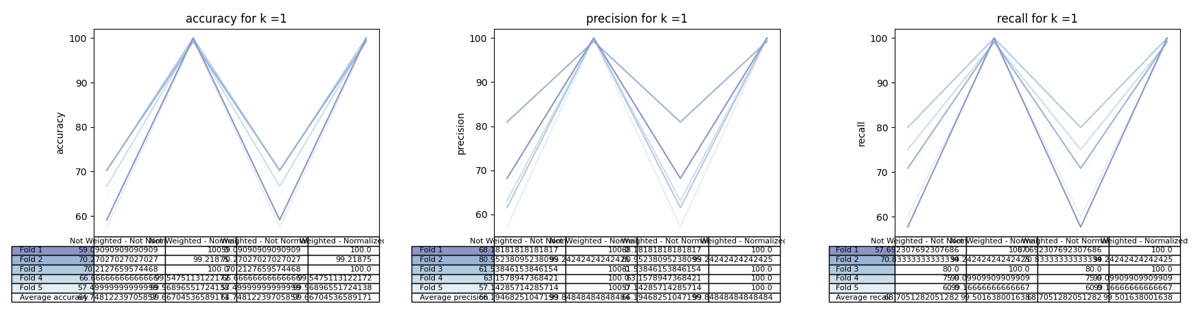

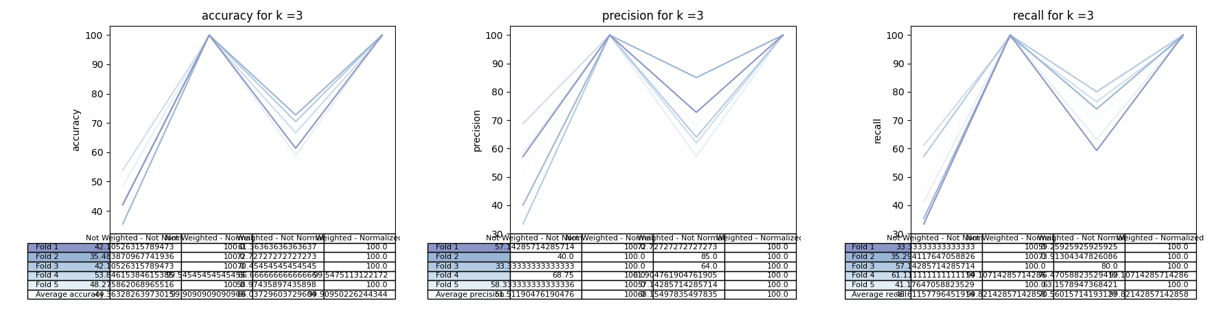

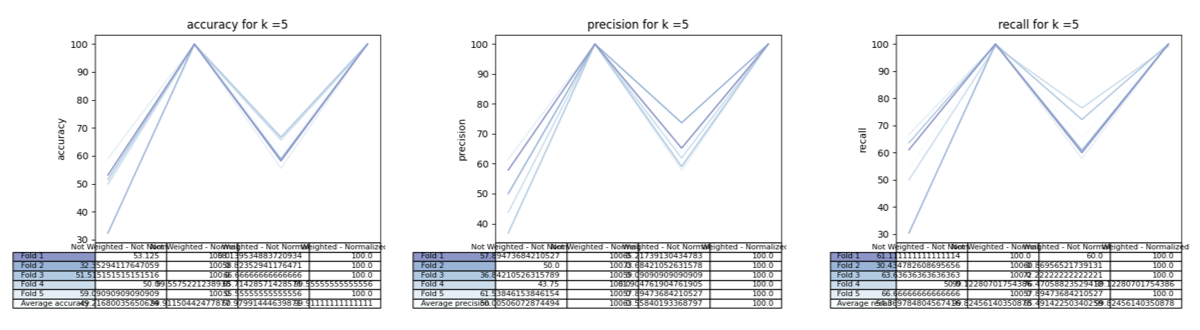

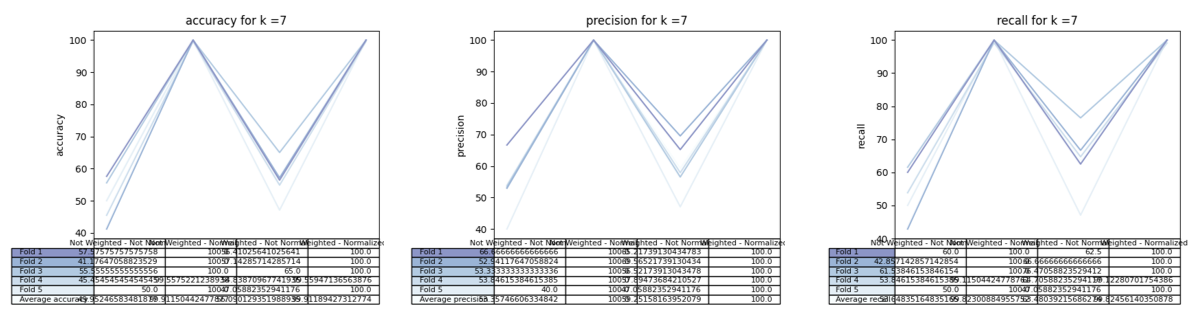

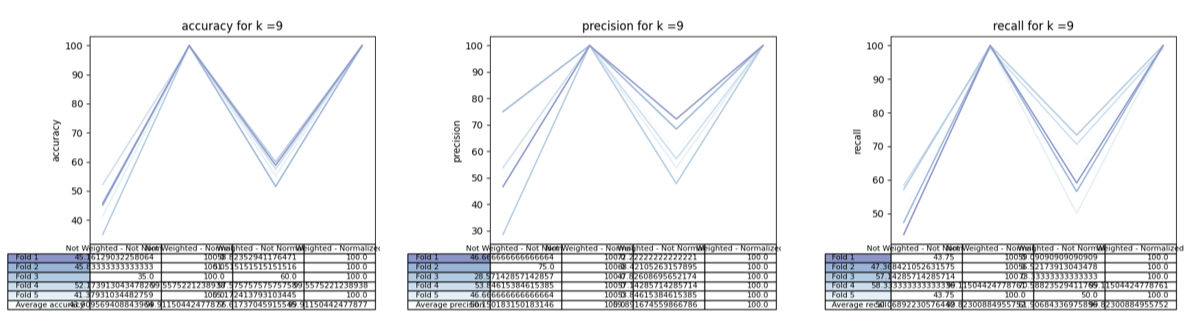

<h3 style="font-family: verdana"><b>1.6.2: Metric Results Collected in Tables</b></h3>

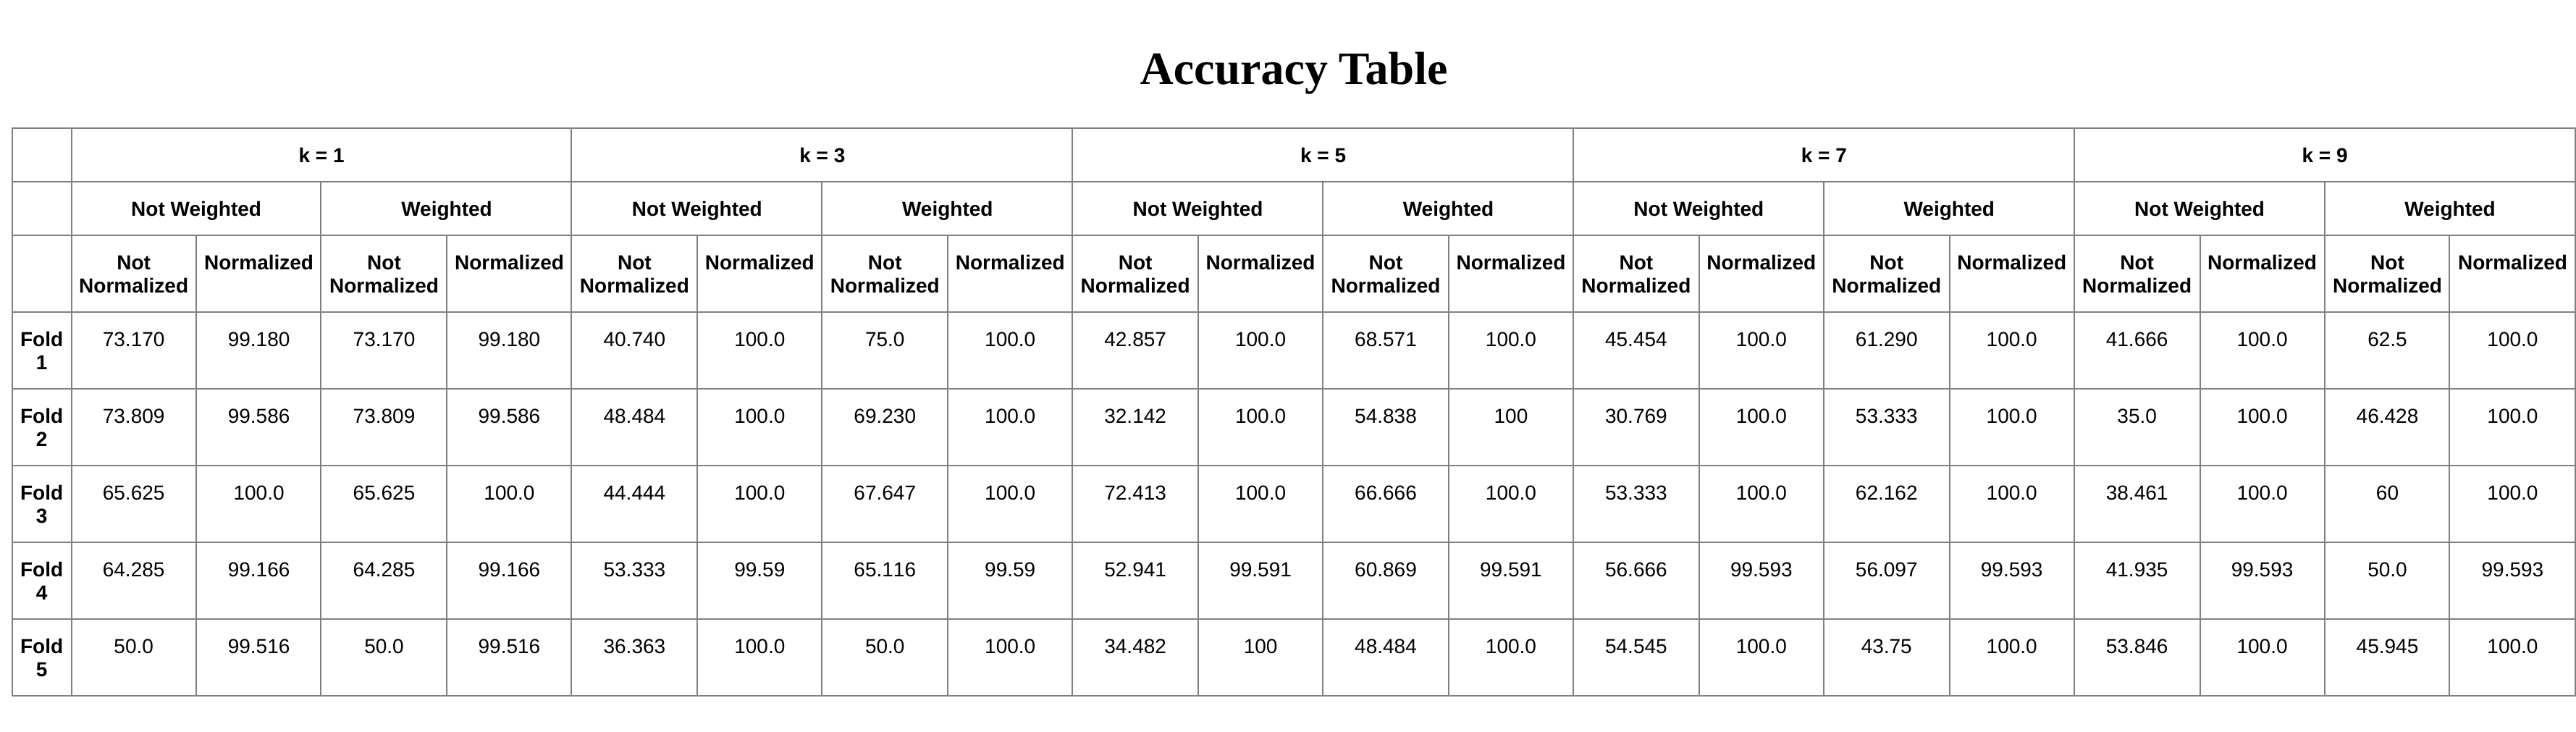

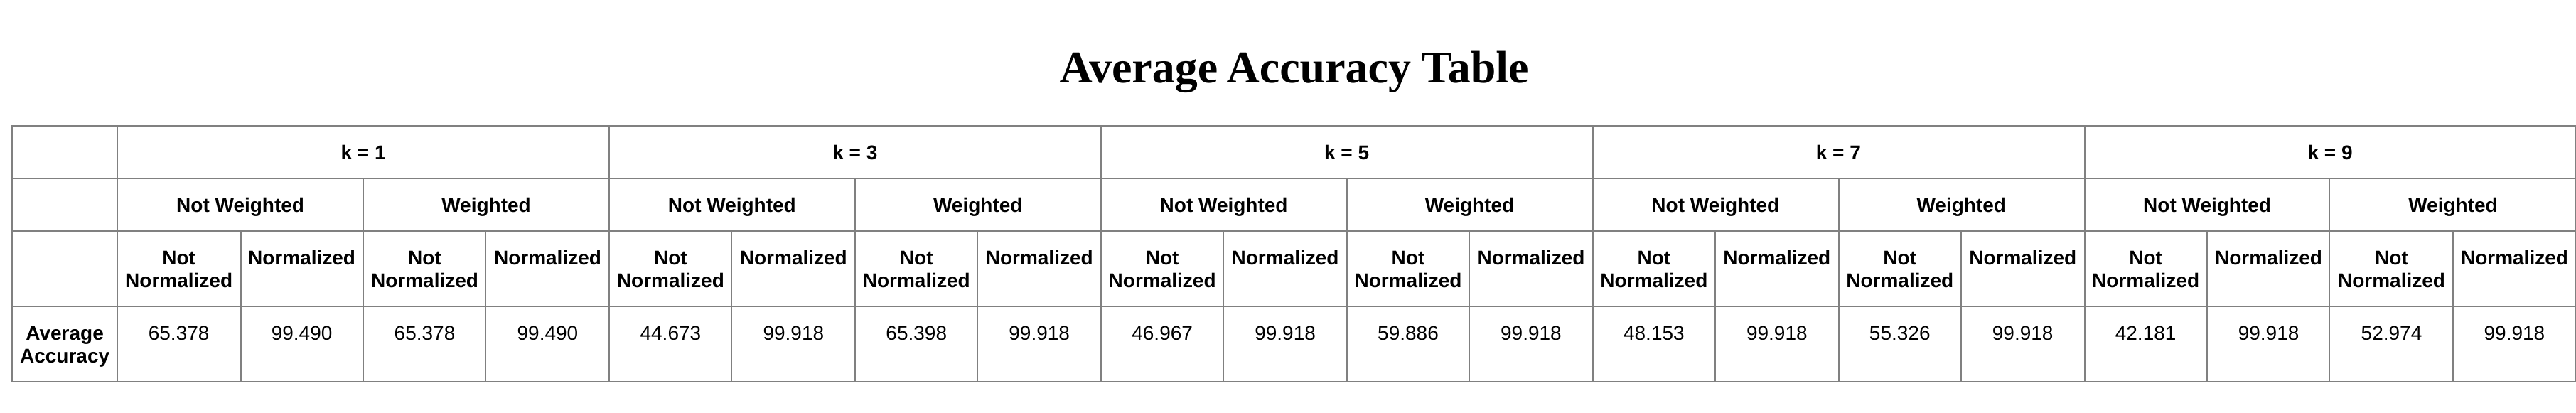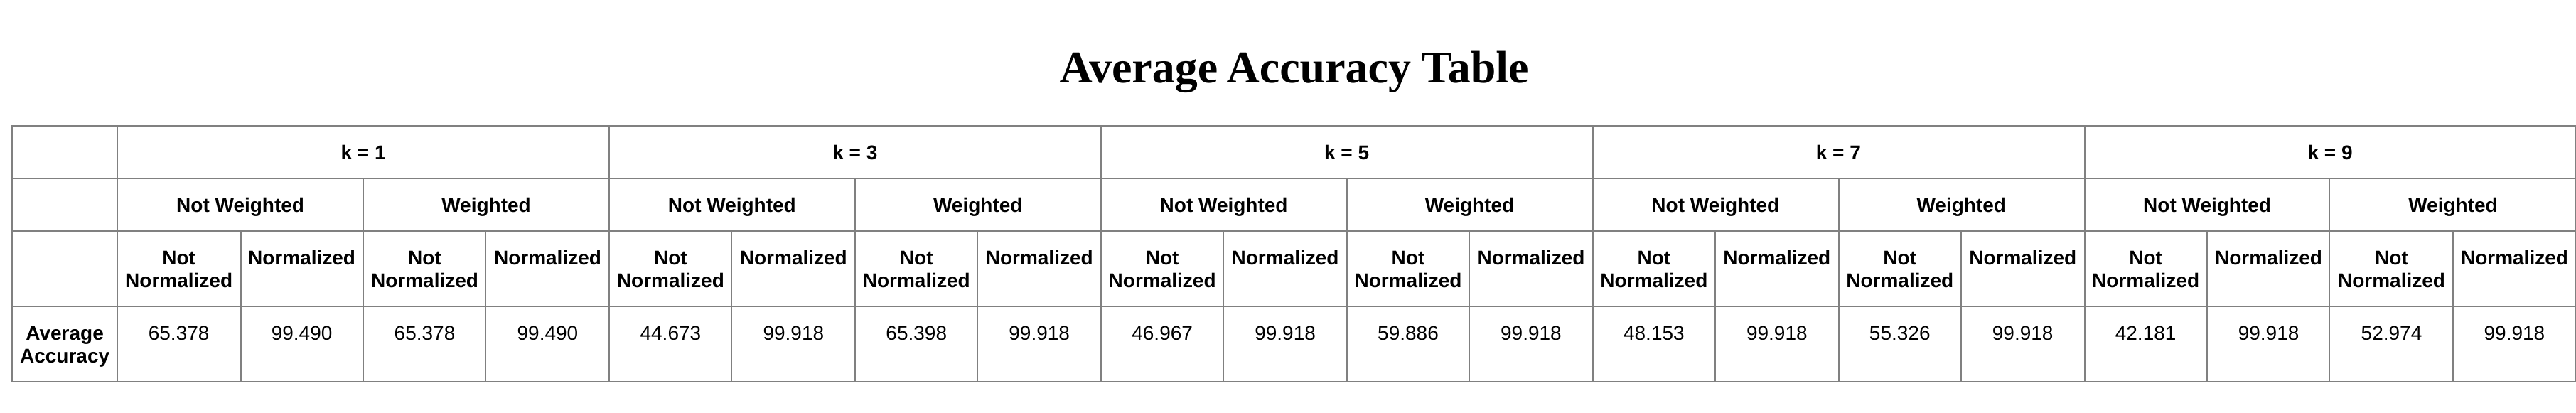

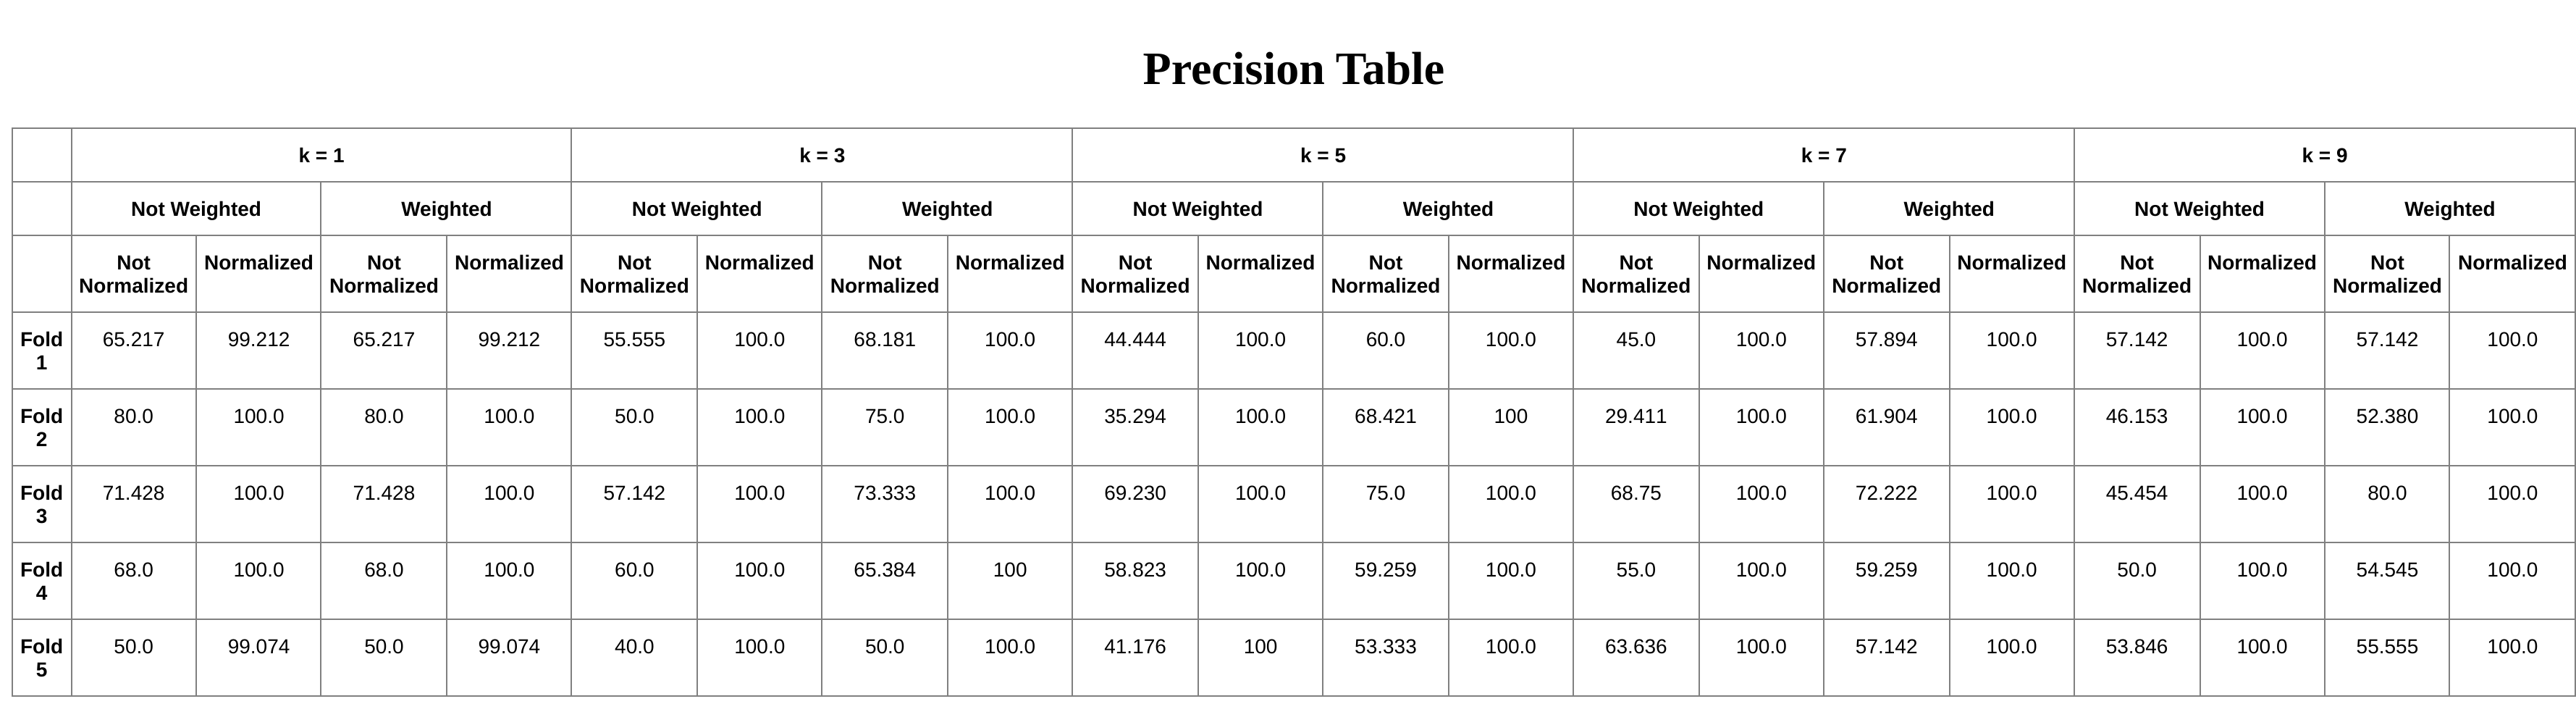

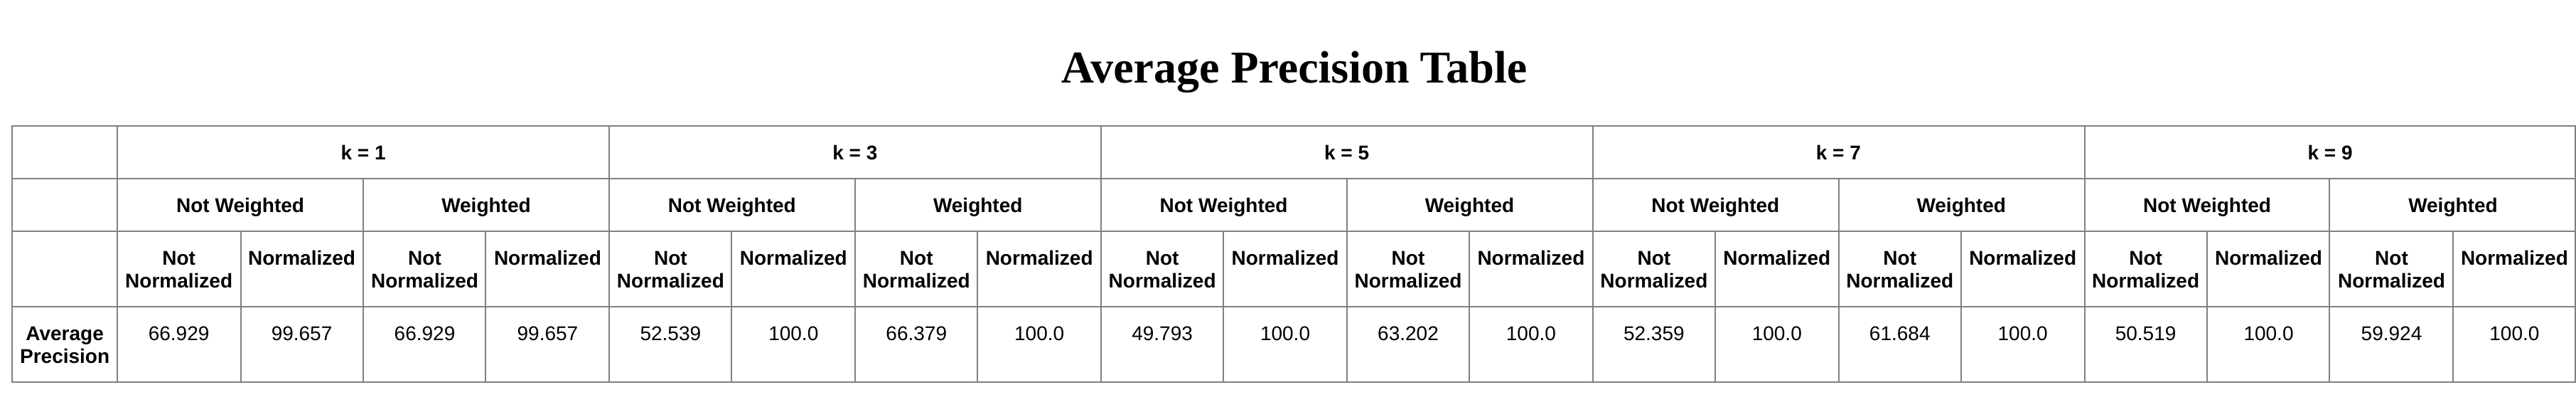

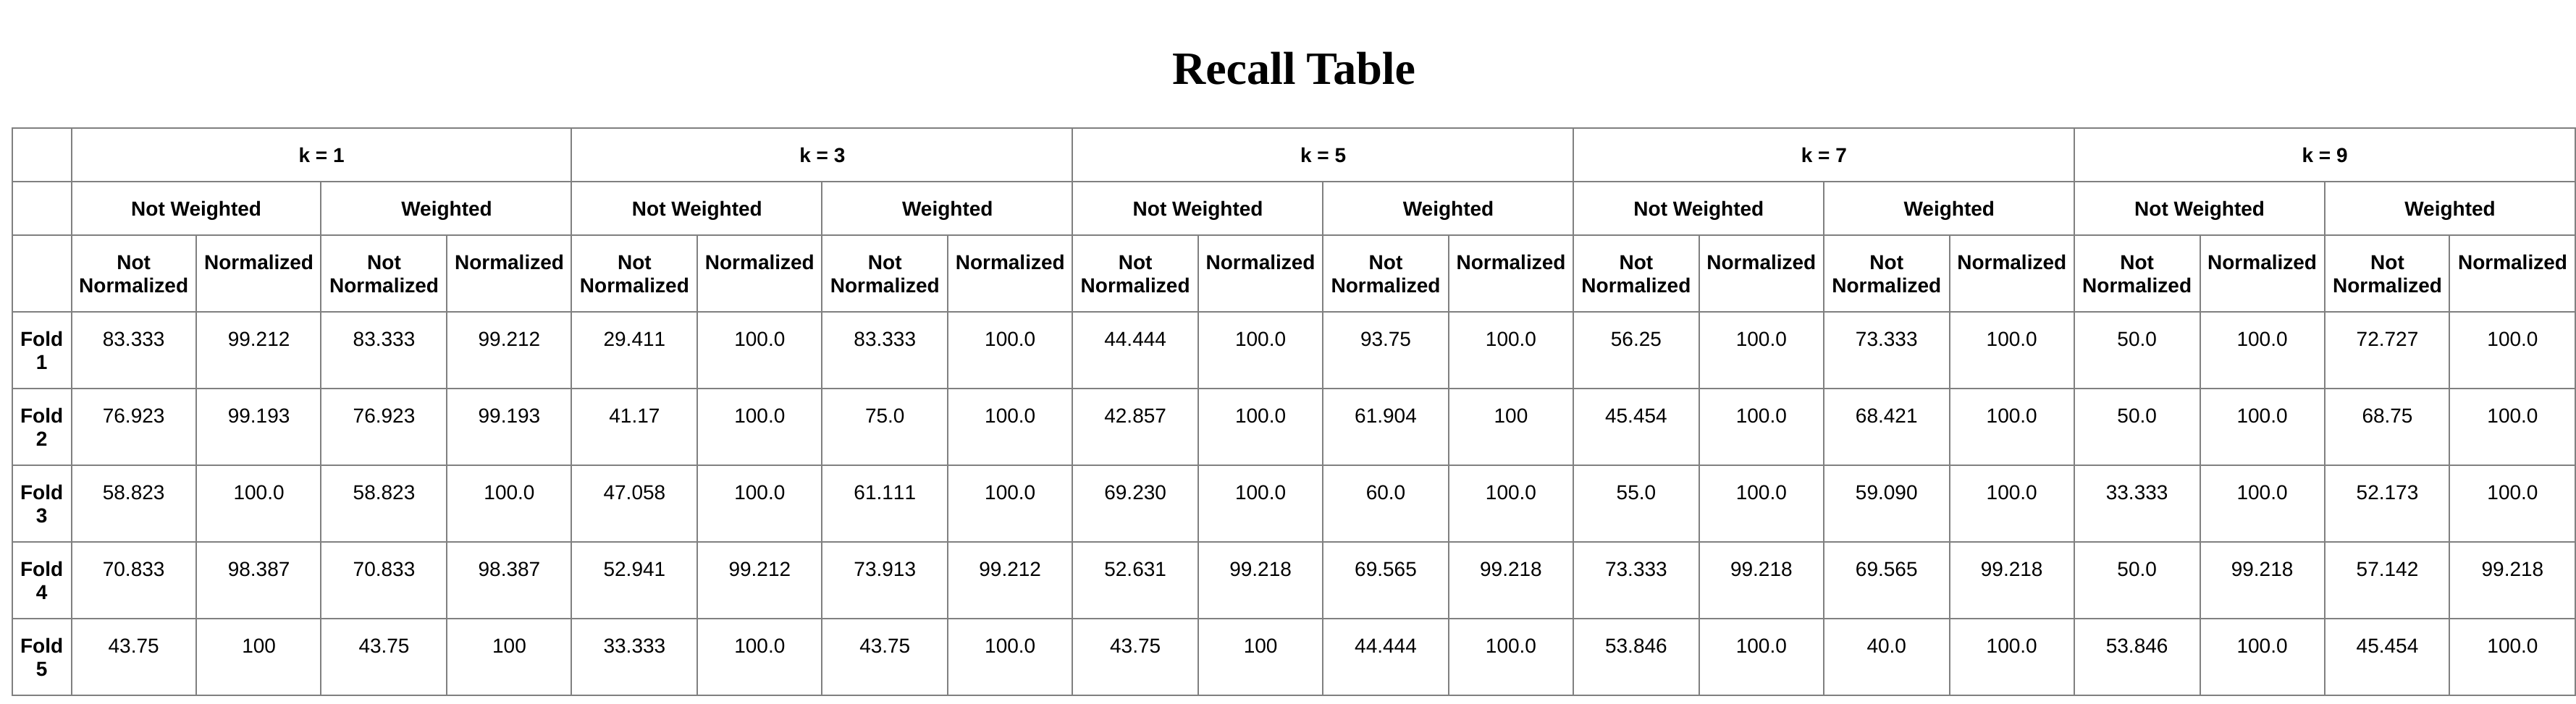

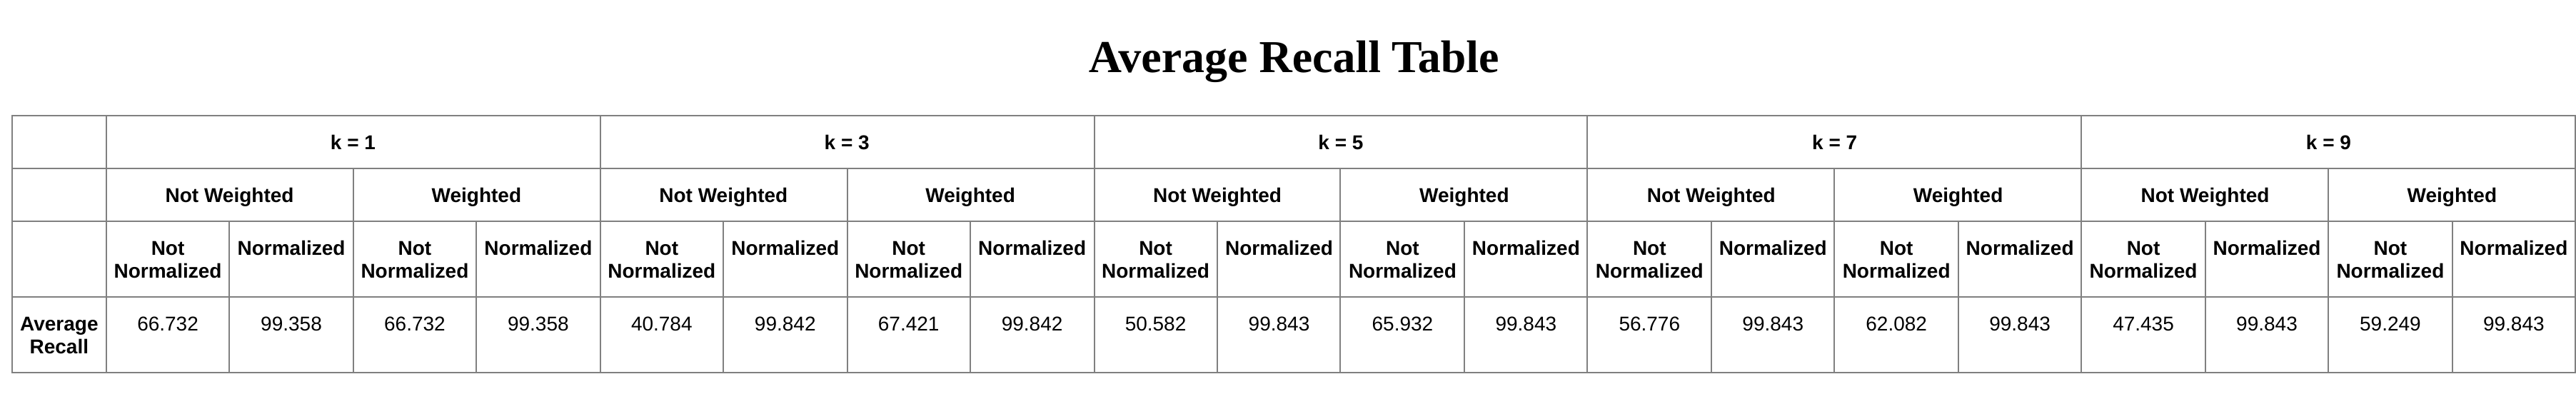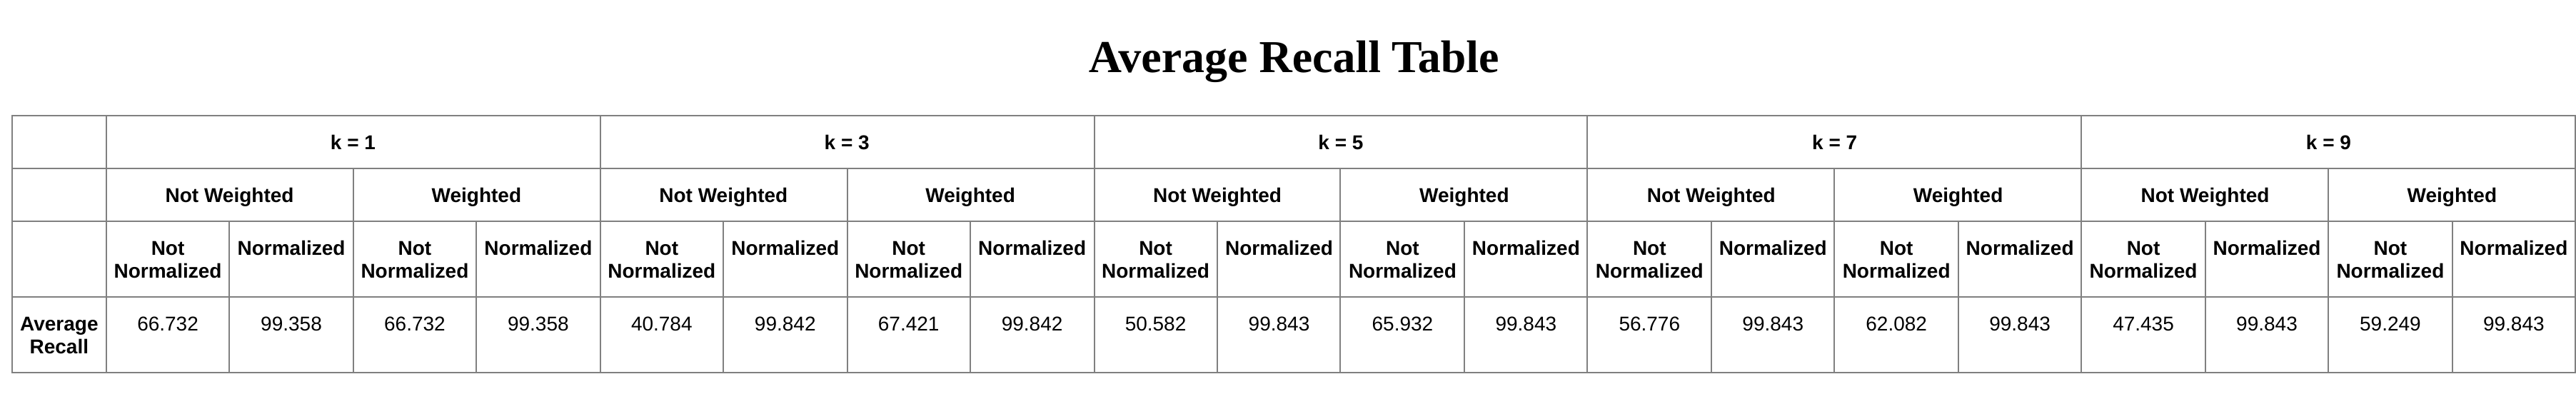

<h3 style="font-family: verdana"><b>1.6.3: Conclusion</b></h3>

<p style="font-family: verdana">When comparing the weighted and unweighted results in the table for the same k and normalized values, we typically find that the weighted KNN produces more effective results. This is due to the fact that weighted KNN offers more accurate measurement when determining the distance between neighbors. The results are more effective when neighbors are scored according to their weights. This is so because we place the most importance on our closest neighbors. The farthest point has the least impact on the point being estimated since the weight is equal to 1/d, which causes it to decrease as the distance increases.</p>

<p style="font-family: verdana">The outliers, that fall outside the predicted range and contrast with the other data can occasionally be found in a dataset. Additionally, certain features' ranges in a dataset may be very different from those of other features. This makes features with a broad range more useful in estimating the model, which might lead to inaccurate estimation. This issue can be resolved with normalization. By shifting the values of each feature such that the smallest value is 0, and then dividing by the maximal value, the normalization in this case is done to the 0–1 range.</p>

<p style="font-family: verdana">We can observe that normalized numbers consistently produce better results when we average out normalized and non-normalized values. The reasons may be the data set's numerous intervals and outlier values, as well as its many properties. It is possible to evaluate the data more accurately when a set interval is chosen.</p>

<p style="font-family: verdana">In conclusion, data normalization raised the accuracy value. When compared to using the standard KNN method, the adoption of Weighted KNN boosted accuracy values. The optimal k-value to pick, based on the data we know, appears to be 1. If an estimation is needed, the model with a normalized, weighted knn procedure and a k value of 1 should be used.</p>
